Loading Libraries and Data

In [1]:
import pickle
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from sklearn.cluster import KMeans
import re
from sklearn.decomposition import PCA
from collections import *


file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_breath1.obj", "rb")
trials_breath = pickle.load(file)
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\static_data.obj", "rb")
static_data = pickle.load(file)
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_raw1.obj", "rb")
trials_raw = pickle.load(file)
metadata = pd.read_csv(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\d2k project metadata.csv")
file = open(r"C:\Users\Mahmoud Al-Madi\Desktop\BCM_SIDS_ML_Summer_22\Data\trials_ecg1.obj", "rb")
trials_ecg = pickle.load(file)

Data Pre-Processing Functions

In [3]:
def compute_timestamps(metadata, mouse_id, all = False, breath_only = False, phase = None, phase2 = None, phase3 = None, phase4 = None):
    """
    Given the required phase(s) and metadata, this function returns all the timestamps in which
    the given phase occurs in seconds as a list \n  

    Inputs:
    1) metadata
    2) mouse_id
    3) all - (default: False) boolean indicating whether all timestamps in experiments are requested as opposed to a select few
    4) breath_only - (default: False) Only if all == True. Excludes all HR Recovery timestamps when set to true
    5) phase, phase2, ... - all phases requested. At least 1 and at most 5 phases.

    if all == True, all timestamps in the experiment is returned \n
    Output formatted as follows: \n
        timestamps_in_s["trial"] = [list of timestamps] \n
        timestamps_in_s["other"]["timestamp"] = [all timestamps for non-trial onset] \n
        timestamps_in_s["other"]["comment"] = [names of all timestamps for not-trial onset]  \n
    if all == false, only specified timestamps are returned \n
    Output is just a 
    """
        
    if not all:
        #retreiving all relevant timestamps
        timestamps_in_hms = list(metadata[((metadata["Comment"] == phase) | (metadata["Comment"] == phase2) | (metadata["Comment"] == phase3) | (metadata["Comment"] == phase4)) & (metadata["source file"] == mouse_id)]["Time"])
        timestamps_in_s = []
        
        #converting timstamps from h:m:s to seconds
        for timestamp in timestamps_in_hms:
            processed_timestamp = re.split(':', timestamp)
            timestamp = [float(i) for i in processed_timestamp]   
            if len(timestamp) == 1:
                timestamps_in_s.append(timestamp[0])
            elif len(timestamp) == 2:
                timestamps_in_s.append(60*timestamp[0]+timestamp[1])
            elif len(timestamp) == 3:
                timestamps_in_s.append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])

        return timestamps_in_s

    else: #retreive all timestamps in experiment
        comments = list(metadata[metadata["source file"] == mouse_id]["Comment"]) 
        timestamps_in_hms = list(metadata[metadata["source file"] == mouse_id]["Time"]) 
        timestamps_in_s = defaultdict(lambda: defaultdict(str))

        if breath_only:  #exclude HR recovery timestamps
            other_comments = []
            other_timestamps = []
            for timestamp in range(0,len(comments)):
                if comments[timestamp] not in ["HR recovery","Hr recovery","HR recovery - No signal", "hr recovery"]:
                    other_comments.append(comments[timestamp])
                    other_timestamps.append(timestamps_in_hms[timestamp])
            timestamps_in_hms = other_timestamps
            comments = other_comments

        timestamps_in_s["trial"] = []
        timestamps_in_s["other"]["timestamp"] = []
        timestamps_in_s["other"]["comment"] = []

        #converting all hms timestamps 
        for stage in range(0,len(comments)):
            if comments[stage].isdecimal(): #if timestamps is trial onset, it is assigned elsewehere
                processed_timestamp = re.split(':', timestamps_in_hms[stage])
                timestamp = [float(i) for i in processed_timestamp]   
                if len(timestamp) == 1:
                    timestamps_in_s["trial"].append(timestamp[0])
                    timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                elif len(timestamp) == 2:
                    timestamps_in_s["trial"].append(60*timestamp[0]+timestamp[1])
                    timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                elif len(timestamp) == 3:
                    timestamps_in_s["trial"].append(3600*timestamp[0]+60*timestamp[1]+timestamp[2])
                    timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                timestamps_in_s["other"]["comment"].append(comments[stage])
            else:
                if not comments[stage][1:].isdecimal():
                    processed_timestamp = re.split(':', timestamps_in_hms[stage])
                    timestamp = [float(i) for i in processed_timestamp]   
                    if len(timestamp) == 1:
                        timestamps_in_s["other"]["timestamp"].append((timestamp[0]))
                    elif len(timestamp) == 2:
                        timestamps_in_s["other"]["timestamp"].append((60*timestamp[0]+timestamp[1]))
                    elif len(timestamp) == 3:
                        timestamps_in_s["other"]["timestamp"].append((3600*timestamp[0]+60*timestamp[1]+timestamp[2]))
                    timestamps_in_s["other"]["comment"].append(comments[stage])

        return timestamps_in_s

def retrieve_phase(meta_data, raw_data, static_data, trial_data,data_type,label1, label2 = None, label3 = None, label4 = None, trial_onset_first = bool, otherlabel = None, otherlabel2 = None):
    """
    Inputs: \n
    1) meta_data (required): metadata \n
    2) raw_data (required):  raw_data \n
    3) static_data (required) \n
    4) trial_data (required): either trials_ecg, trials_breath \n
    5) data_type (required): either "ECG" or "Breathing_flow_signal" \n
    6) trial_onset_first (required): specify whether the desired phase starts or ends with trial onset or not. Set to False if other_label is phase onset \n
    7) label1, label2,.. label4 (optional) (default=None): string representing desired phase timestamp, has multiple options in case the same phase was referenced in different ways in the metadata \n
    8) other_label (optional) (default=None): specify other end of phase if it's not a trial onset (e.g. looking for interval from apnea start to recovery
                 as opposed to looking for phase HR to next trial onset or looking for phase trial onset to apnea start) \n
    
    Outputs: \n
    1) interval_information_df - dataframe on mouse ID and experimental type information encoded as natural numbers for plotting purposes \n
    2) min_interval_length - minimum length of all the phases extracted in this function \n
    3) phase_interval_per_mouse - function mapping each mouse to a mapping from a number to its corresponding phase
                               (i.e 3 phase means 1:phase1, 2:phase2,3:phase3) where each
                                phase is a dataframe \n
    Method: \n
    Upon specificying the desired phase boundaries (HR recovery to trial onset/ trial onset to apnea/ eupnea recovery to trial onset ..etc) \n
    this function returns the desired phases as a dataframe in the format specified above. This function defaults to finding the phases that either \n
    start or ends with trial onset unless other_label is specified in which case other_label offsets that defualt setting in case a start/end \n
    different from trial onset is desired.
    """
    
    mice = list(trial_data.keys())
    phase_interval_per_mouse = defaultdict(lambda : defaultdict(int))
    min_interval_length = float("inf")

    phase_interval_number = []
    mouse_IDs = []
    mouse_ID_no = []
    mouse_type = []
    mouse_type_no = []
    mouse_genotypes = {}
    
    #
    i = 0
    for mouse_line in static_data["Line"].unique():
        for exp_type in static_data["Genotype"].unique():
            i += 1
            mouse_genotypes[mouse_line + " " + exp_type] = i
    j = 0
    #going through all the mice to extract the desired phases from each of their experiments
    for mouse in mice:
        j += 1
        print("Currently retrieving interval information for mouse {0}. Progress: {1}%" .format(mouse,100*((mice.index(mouse) + 1)/len(mice))))

        #different method for extracting the desired phase start/end timstamps depending on whether phase starts/ends with a trial onset
        if otherlabel:
            other_phase_timestamps = []
            other_phase_timestamps = compute_timestamps(meta_data,str(mouse), all=False, phase=otherlabel, phase2=otherlabel2)
        else:
            trials_survived = int(raw_data[str(mouse)]["raw"]["trial_no"].unique()[-1])
            other_phase_timestamps = []
            if trial_onset_first:
                for trial in range(1,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)
            else:
                for trial in range(2,trials_survived+1):
                    timestamp_now = int(compute_timestamps(meta_data,str(mouse),all=False,phase=str(trial))[0])
                    if timestamp_now < len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                        other_phase_timestamps.append(timestamp_now)

        #compute timestamps for other end of inteval
        phase_onset_timestamps = compute_timestamps(meta_data,str(mouse), phase=label1, phase2 = label2, phase3= label3, phase4= label4)
        
        #even out timestamps list in case this mouse has not completed a full iteration of desired phase
        if len(phase_onset_timestamps) > len(other_phase_timestamps):
            del(phase_onset_timestamps[-1])
        elif len(phase_onset_timestamps) < len(other_phase_timestamps):
            del(other_phase_timestamps[-1])

        #removing timestamp if it's out of range of the data we're given. This is due to error in metadata/data provided
        for timestamp in phase_onset_timestamps:
            if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                phase_onset_timestamps.remove(timestamp)       
        if otherlabel:
            for timestamp in other_phase_timestamps:
                if int(timestamp) > len(raw_data[str(mouse)]["raw"][str(data_type)]) * 1e-3:
                    other_phase_timestamps.remove(timestamp)

        #extracting each phase one at a time
        for phase_interval in range(0,len(phase_onset_timestamps)):          
            #we determine how to set our interval starting and ending indices based on whether the desired phase starts or ends with trial onset
            if not trial_onset_first:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(phase_onset_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(other_phase_timestamps[phase_interval]) > 0]
            else:
                current_interval_start = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.ceil(other_phase_timestamps[phase_interval]) > 0]
                current_interval_end = raw_data[str(mouse)]["raw"].loc[raw_data[str(mouse)]["raw"]["Timestamp"] - math.floor(phase_onset_timestamps[phase_interval]) > 0]
            
            #retrieving our desired phase start and ending index
            current_interval_start_timestamp = current_interval_start["Timestamp"].iloc[0]
            current_interval_end_timestamp = current_interval_end["Timestamp"].iloc[0]

            start_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_start_timestamp][0]
            end_index = raw_data[str(mouse)]["raw"].index[raw_data[str(mouse)]["raw"]["Timestamp"] > current_interval_end_timestamp][0]
        
            #find current interval and include it in phase_interval_per_mouse
            if (start_index < len(raw_data[str(mouse)]["raw"][str(data_type)])) & (end_index < len(raw_data[str(mouse)]["raw"][str(data_type)])):
                current_interval = raw_data[str(mouse)]["raw"][str(data_type)][start_index:end_index].reset_index()
                phase_interval_per_mouse[mouse][phase_interval] = current_interval
            
            #finding minium_interval_length
            if len(current_interval) < min_interval_length:
                min_interval_length = len(current_interval)

            if min_interval_length == 0:
                raise ValueError("{}, {}, mouse:{}, start: {}, end: {}, total length: {}" .format(other_phase_timestamps, phase_onset_timestamps, mouse, start_index, end_index, 
                                                                                            len(raw_data[str(mouse)]["raw"][str(data_type)])))

            #collect information to create interval_information_df
            mouse_ID_no.append(j)
            mouse_IDs.append(mouse)
            phase_interval_number.append(phase_interval + 1)
            genotype = static_data[static_data["MUID"] == str(mouse)]["Line"].item() + " " + static_data[static_data["MUID"] == str(mouse)]["Genotype"].item()
            mouse_type.append(genotype)
            mouse_type_no.append(mouse_genotypes[genotype])

    #creating inverval_information_df 
    interval_information_df = pd.DataFrame(list(zip(mouse_ID_no,mouse_IDs, phase_interval_number, mouse_type, mouse_type_no)), columns = ["Mouse ID #","Mouse ID", "Recovery interval #", "Mouse Type", "Mouse Type #"])

    return interval_information_df, min_interval_length, phase_interval_per_mouse


In [4]:
info_df, min_length, phase_data_df = retrieve_phase(metadata, trials_raw, static_data, trials_breath, "Breathing_flow_signal", label1= "eupnea recovery", label2="eupnea starts", trial_onset_first=False)

Currently retrieving interval information for mouse M20864. Progress: 5.0%
Currently retrieving interval information for mouse M20865. Progress: 10.0%
Currently retrieving interval information for mouse M20867. Progress: 15.0%
Currently retrieving interval information for mouse M20868. Progress: 20.0%
Currently retrieving interval information for mouse M20869. Progress: 25.0%
Currently retrieving interval information for mouse M20870. Progress: 30.0%
Currently retrieving interval information for mouse M20874. Progress: 35.0%
Currently retrieving interval information for mouse M21480. Progress: 40.0%
Currently retrieving interval information for mouse M21481. Progress: 45.0%
Currently retrieving interval information for mouse M21483. Progress: 50.0%
Currently retrieving interval information for mouse M21484. Progress: 55.00000000000001%
Currently retrieving interval information for mouse M21486. Progress: 60.0%
Currently retrieving interval information for mouse M21487. Progress: 65.0%


Filtering Functions

In [6]:
from scipy.signal import butter, filtfilt
def butter_lowpass(lowcutoff, highcutoff, fs, order=5):
        nyq = 0.5 * fs
        lowcutoff = lowcutoff / nyq        
        highcutoff = highcutoff / nyq
        a,b = butter(order, [lowcutoff, highcutoff], analog=False, btype='bandpass',output = 'ba')
        return a,b

def butter_bandpass_filter(data, lowcutoff, highcutoff, fs, order=5):
        a,b = butter_lowpass(lowcutoff, highcutoff, fs, order=order)
        y = filtfilt(a,b, data)
        return y

def bandpass_filter(low, high, fs,order, signal):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz


    plt.figure(figsize = (8,8))
    plt.plot(signal, label='Raw signal')
    plt.title("Unfiltered signal", size = 10)
    plt.xlabel("Time (ms)", size = 10)
    plt.ylabel("Ventflow", size = 10)

    filtered_data = butter_bandpass_filter(signal, low, high, fs, order)

    plt.figure(figsize = (8,8))
    plt.plot(filtered_data)
    plt.title("Bandpass Filtered Signal, Cutoff = {}-{} Hz" .format(low,high), size = 10)
    plt.xlabel("Time (ms)", size = 10)
    plt.ylabel("Ventflow", size = 10)

    return filtered_data
    

Analyzing Frequency Content

0
[-0.281875  -0.28375   -0.2846875 ... -0.1959375 -0.1953125 -0.195625 ]
(100000,)
(100000,)
0
[-0.03267094 -0.03419422 -0.03560821 ...  0.00224537  0.00222659
  0.00224028]
100000   -0.281875
100001   -0.283750
100002   -0.284687
100003   -0.285000
100004   -0.286250
            ...   
199995   -0.196250
199996   -0.195937
199997   -0.195937
199998   -0.195312
199999   -0.195625
Name: Breathing_flow_signal, Length: 100000, dtype: float32


Text(0.5, 1.0, 'Spectrogram of the Signal, Hanning Window, NFFT = 256, 50% Overlap')

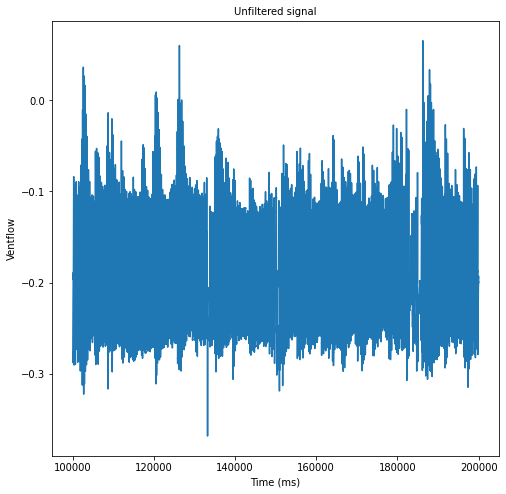

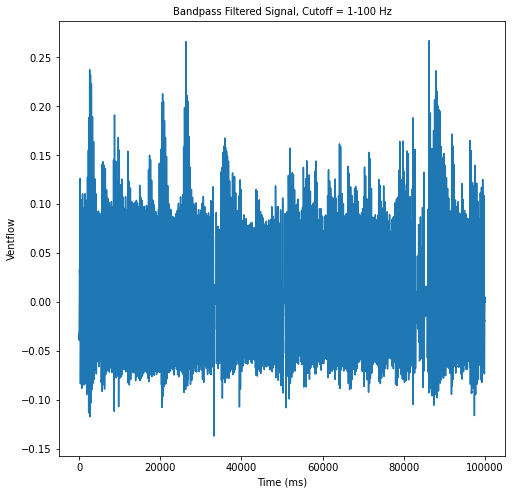

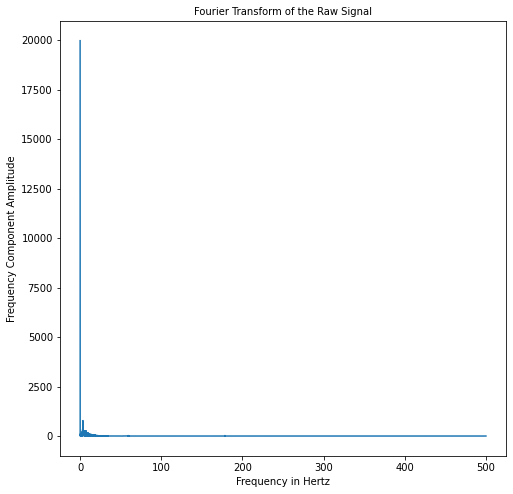

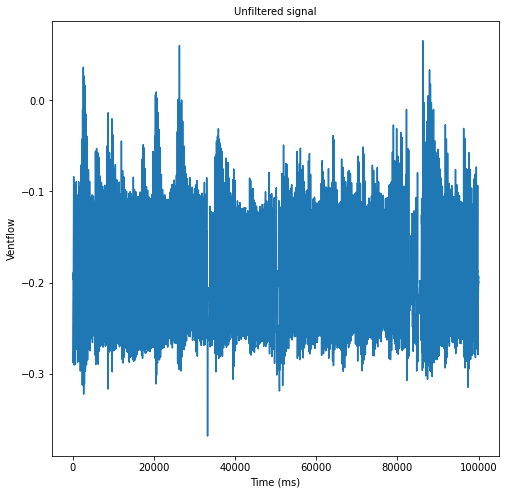

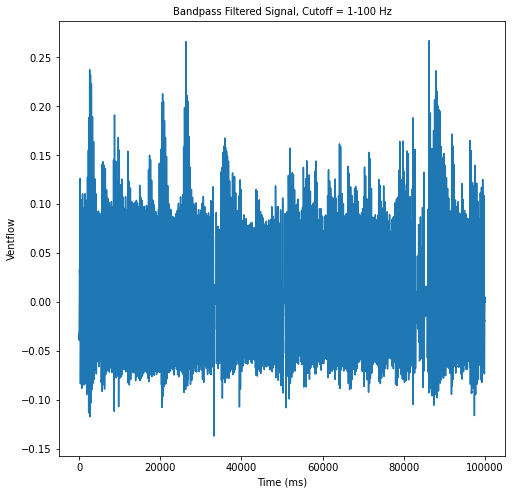

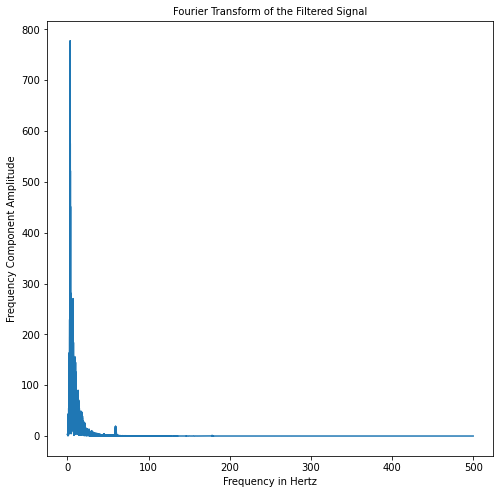

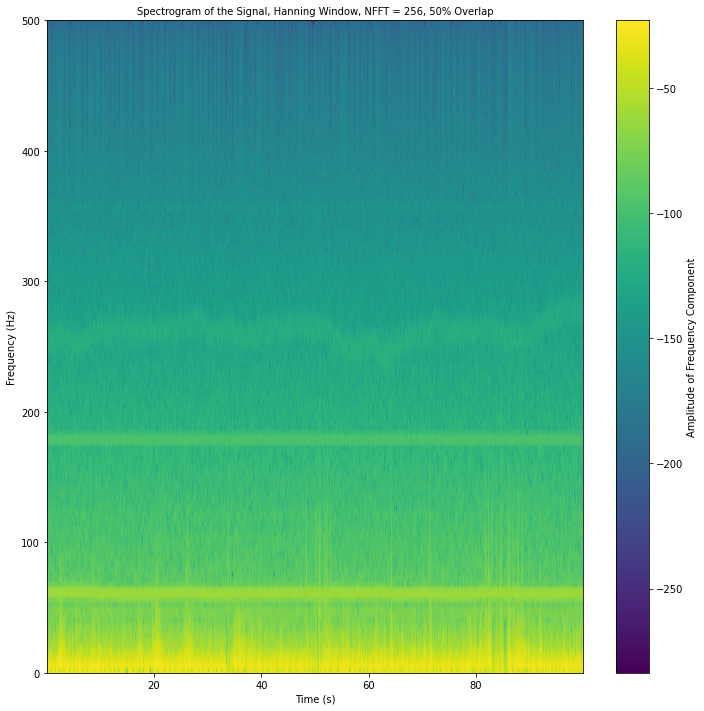

In [7]:
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt

mouse_data = phase_data_df["M21488"][2]

start = 100000
end = 200000
ecg_minisample = mouse_data["Breathing_flow_signal"][start:end]
SAMPLE_RATE = 1000
DURATION = end - start + 1
N = DURATION

print(np.sum(np.isnan(np.array(ecg_minisample))))

filtered_signal = bandpass_filter(1, 100, 1000, 2, ecg_minisample)
filtered_signal = ecg_minisample
yf = rfft(np.array(ecg_minisample))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

plt.figure(figsize = (8,8))
plt.plot(xf, np.abs(yf))
plt.xlabel('Frequency in Hertz', size= 10)
plt.ylabel("Frequency Component Amplitude", size= 10)
plt.title("Fourier Transform of the Raw Signal", size= 10)

print(np.array(ecg_minisample))
filtered_signal = bandpass_filter(1, 100, 1000, 2, np.array(ecg_minisample))

print(np.shape(filtered_signal))
print(np.shape(ecg_minisample))
print(np.sum(np.isnan(np.array(filtered_signal))))
print(filtered_signal)
print(ecg_minisample)
yf = rfft(np.array(filtered_signal))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

plt.figure(figsize = (8,8))
plt.plot(xf, np.abs(yf))
plt.xlabel('Frequency in Hertz', size= 10)
plt.ylabel("Frequency Component Amplitude", size= 10)
plt.title("Fourier Transform of the Filtered Signal", size= 10)

plt.figure(figsize = (12,12))
spectrum, freqs, t, im = plt.specgram(filtered_signal, Fs = 1000, mode = "magnitude", NFFT = 256, noverlap = 128)
plt.xlabel("Time (s)", size = 10)
plt.ylabel("Frequency (Hz)", size = 10)
cbar = plt.colorbar()
cbar.set_label('Amplitude of Frequency Component', rotation=90, size = 10)
plt.title("Spectrogram of the Signal, Hanning Window, NFFT = 256, 50% Overlap", size = 10)

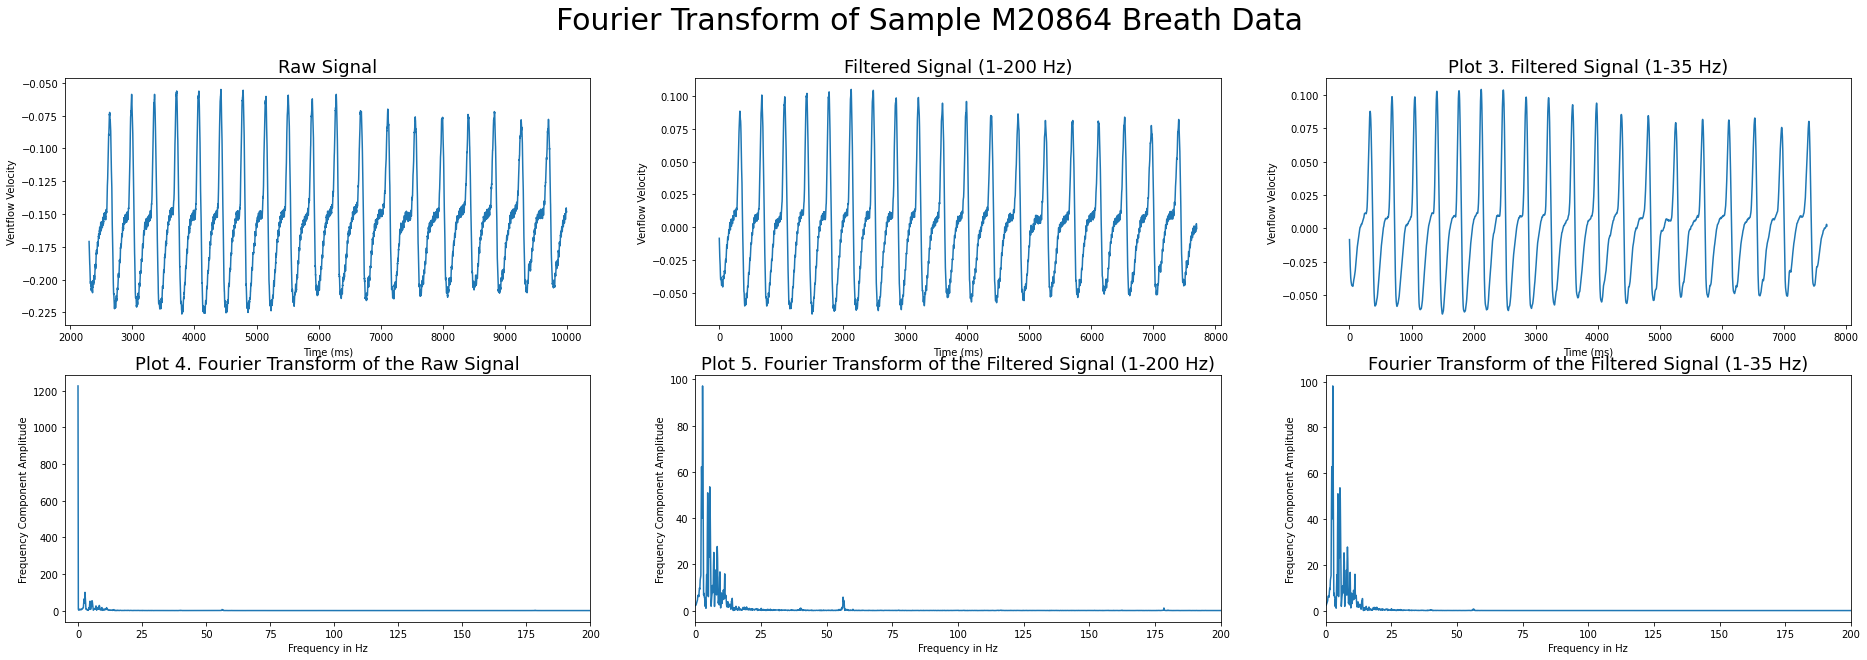

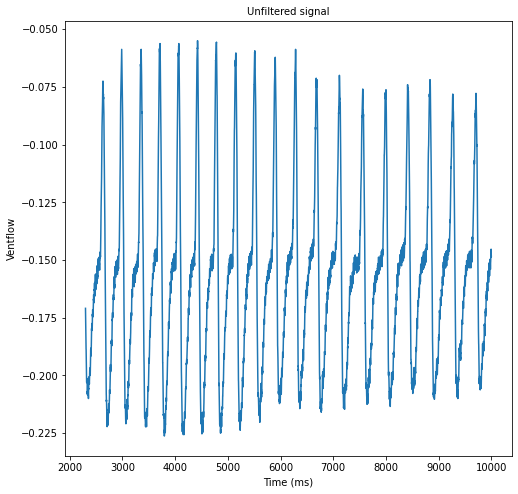

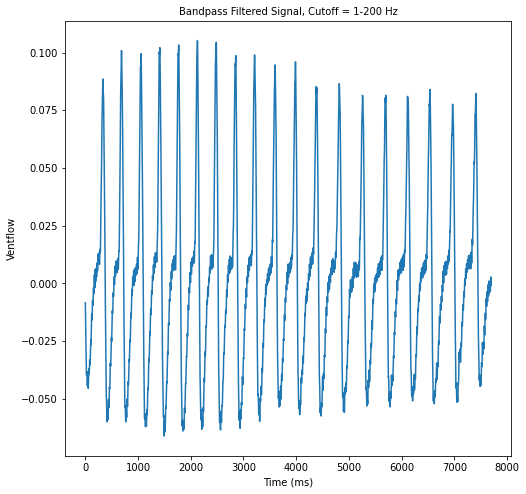

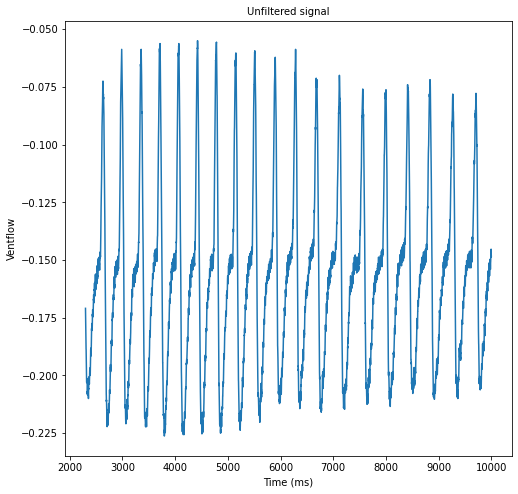

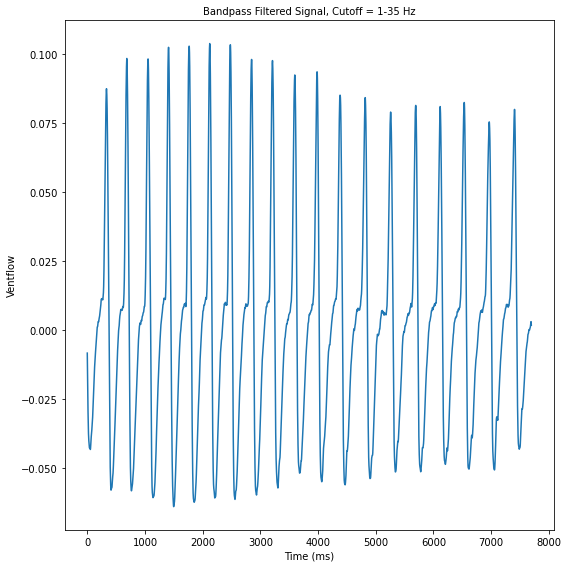

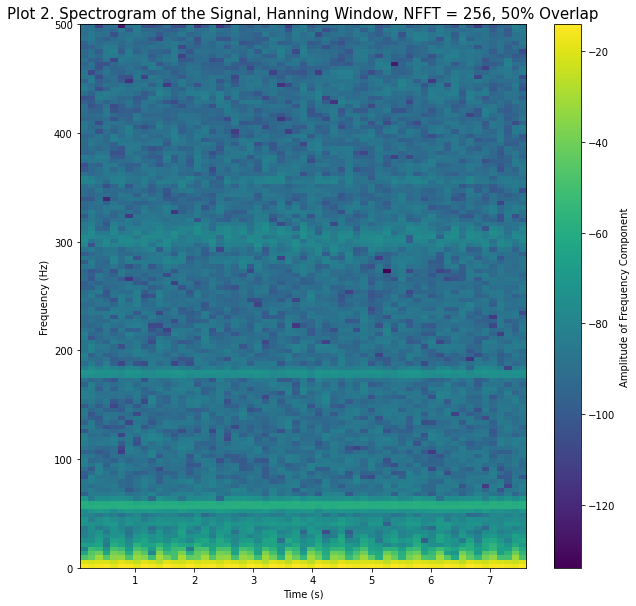

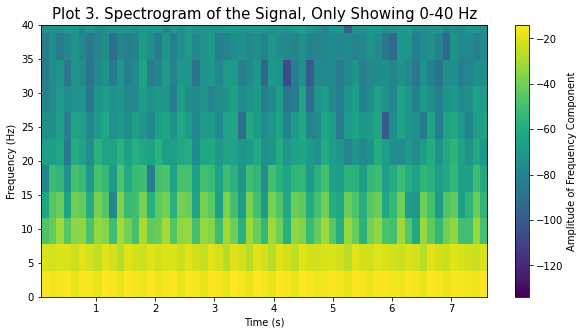

In [35]:


signal = phase_data_df["M20864"][1]["Breathing_flow_signal"][2300:10000]

fig = plt.figure(figsize = (32,10))

plt.suptitle("Fourier Transform of Sample M20864 Breath Data", size=30)

ax = fig.add_subplot(2,3,1)
ax.plot(signal)
ax.set_title("Raw Signal", size=18)
ax.set_xlabel("Time (ms)", size=10)
ax.set_ylabel("Ventflow Velocity", size=10)

SAMPLE_RATE = 1000
DURATION = len(signal) + 1
N = DURATION


yf = rfft(np.array(signal))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

ax = fig.add_subplot(2,3,4)
ax.plot(xf, np.abs(yf))
ax.set_xlabel('Frequency in Hz', size= 10)
ax.set_ylabel("Frequency Component Amplitude", size= 10)
ax.set_title("Plot 4. Fourier Transform of the Raw Signal", size=18)
ax.set_xlim(-5,200)

filtered_signal = bandpass_filter(1, 200, 1000, 2, signal)

ax = fig.add_subplot(2,3,2)
ax.plot(filtered_signal)
ax.set_title("Filtered Signal (1-200 Hz)", size= 18)
ax.set_xlabel("Time (ms)", size=10)
ax.set_ylabel("Venflow Velocity", size=10)

yf = rfft(np.array(filtered_signal))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

ax = fig.add_subplot(2,3,5)
ax.plot(xf, np.abs(yf))
ax.set_xlabel('Frequency in Hz', size= 10)
ax.set_ylabel("Frequency Component Amplitude", size= 10)
ax.set_title("Plot 5. Fourier Transform of the Filtered Signal (1-200 Hz)", size= 18)
ax.set_xlim(0,200)

filtered_signal = bandpass_filter(1, 35, 1000, 2, signal)

ax = fig.add_subplot(2,3,3)
ax.plot(filtered_signal)
ax.set_xlabel("Time (ms)", size=10)
ax.set_ylabel("Venflow Velocity", size=10)
ax.set_title("Plot 3. Filtered Signal (1-35 Hz)", size= 18)

yf = rfft(np.array(filtered_signal))
xf = rfftfreq(math.ceil(N), 1 / SAMPLE_RATE)

ax = fig.add_subplot(2,3,6)
ax.plot(xf, np.abs(yf))
ax.set_xlabel('Frequency in Hz', size= 10)
ax.set_ylabel("Frequency Component Amplitude", size= 10)
ax.set_title("Fourier Transform of the Filtered Signal (1-35 Hz)", size= 18)
ax.set_xlim(0,200)

plt.tight_layout()
fig.savefig("fourier_transform.jpg", dpi = 300)

###################

fig = plt.figure(figsize = (10,10))
spectrum, freqs, t, im = plt.specgram(signal, Fs = 1000, mode = "magnitude", NFFT = 256, noverlap = 128)
plt.xlabel("Time (s)", size = 10)
plt.ylabel("Frequency (Hz)", size = 10)
cbar = plt.colorbar()
cbar.set_label('Amplitude of Frequency Component', rotation=90, size = 10)
plt.title("Plot 2. Spectrogram of the Signal, Hanning Window, NFFT = 256, 50% Overlap", size = 15)
#plt.axhline(60, c="yellow")
#plt.axhline(40, c="blue")

fig.savefig("spectrogram_full.jpg", dpi=300)

fig =  plt.figure(figsize = (10,5))
spectrum, freqs, t, im = plt.specgram(signal, Fs = 1000, mode = "magnitude", NFFT = 256, noverlap = 128)
plt.xlabel("Time (s)", size = 10)
plt.ylabel("Frequency (Hz)", size = 10)
cbar = plt.colorbar()
cbar.set_label('Amplitude of Frequency Component', rotation=90, size = 10)
plt.title("Plot 3. Spectrogram of the Signal, Only Showing 0-40 Hz", size = 15)
#plt.axhline(60, c="yellow")
#plt.axhline(40, c="blue")

plt.ylim(0,40)
fig.savefig("spectrogram_cut.jpg", dpi=300)

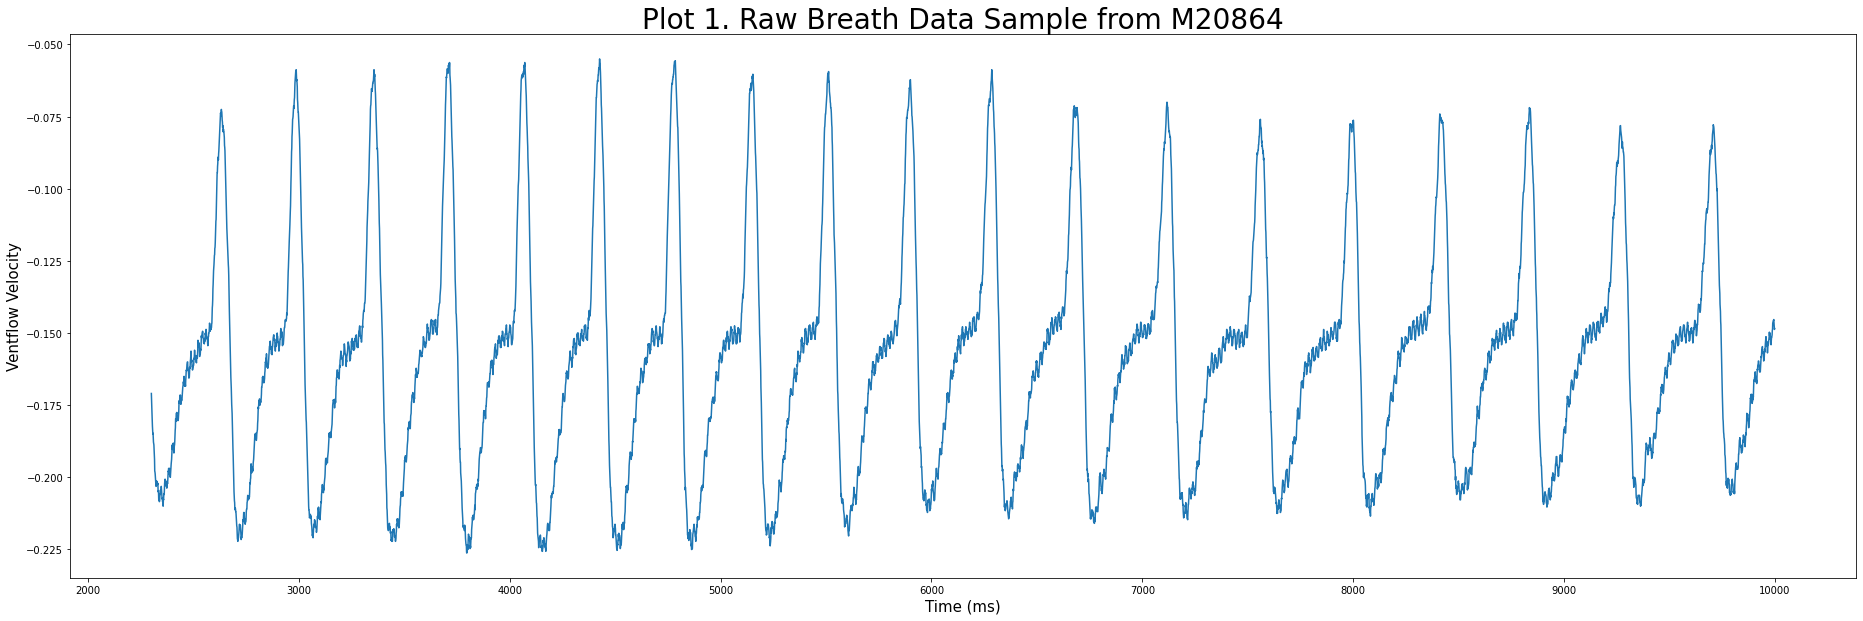

In [31]:
signal = phase_data_df["M20864"][1]["Breathing_flow_signal"][2300:10000]

fig = plt.figure(figsize = (32,10))

plt.plot(signal)
plt.title("Plot 1. Raw Breath Data Sample from M20864", size=28)
plt.xlabel("Time (ms)", size=15)
plt.ylabel("Ventflow Velocity", size=15)

fig.savefig("raw_data.jpeg", dpi = 300)

Visualizing Spectrograms

3
1
[2140.149]
2
[2494.849]
3
[2863.5]
[2140.149]
[2494.849]
[2863.5]


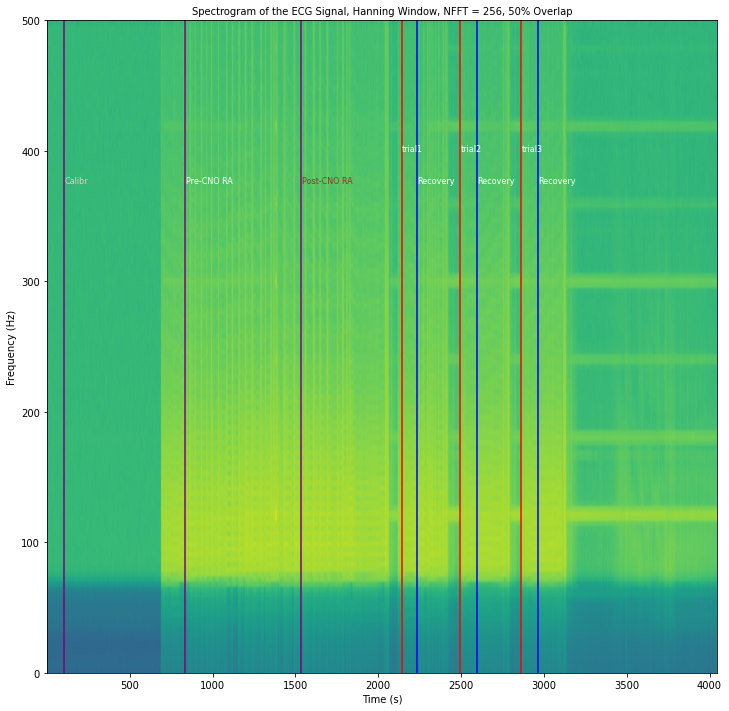

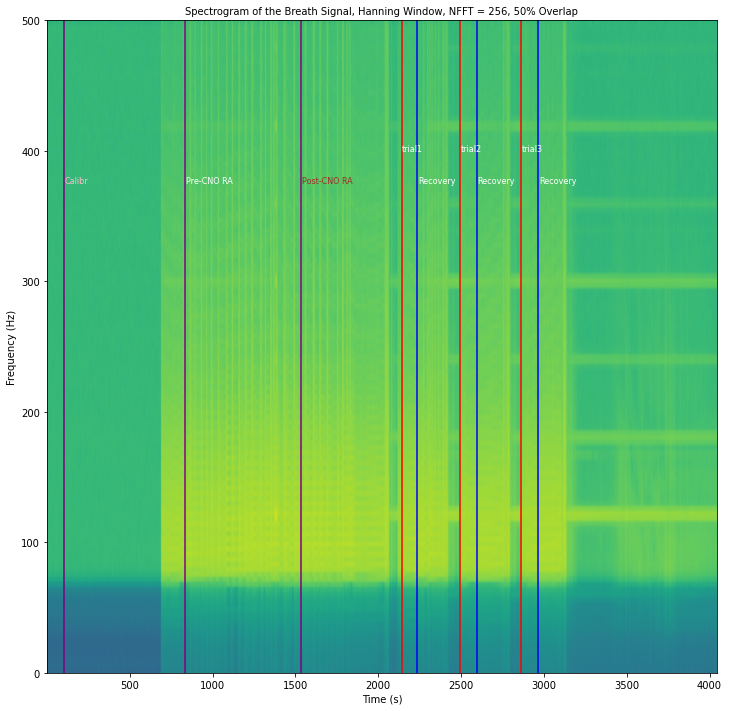

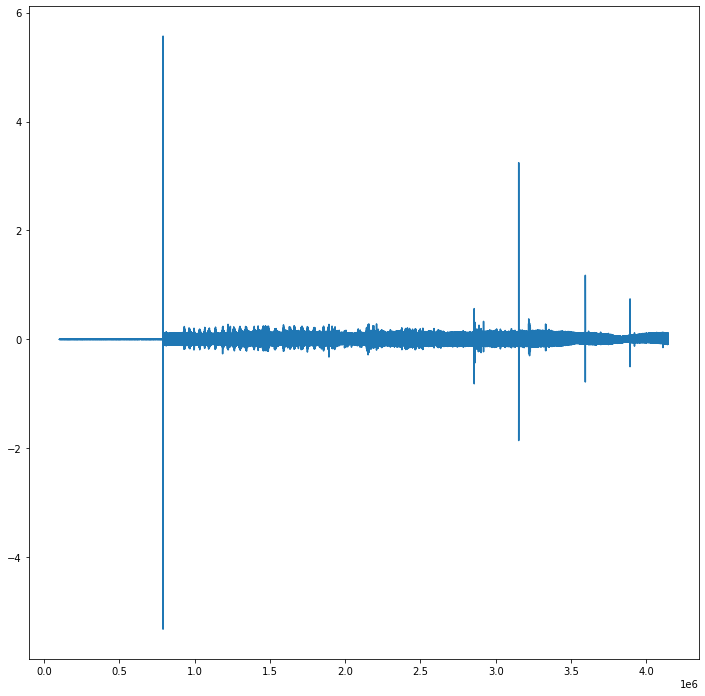

In [12]:
for mouse in ["M20864"]:
    plt.figure(figsize = (12,12))
    spectrum, freqs, t, im = plt.specgram(trials_raw[mouse]["raw"]["ECG"], Fs = 1000, mode = "magnitude", NFFT = 256, noverlap = 128)
    plt.xlabel("Time (s)", size = 10)
    plt.ylabel("Frequency (Hz)", size = 10)
    num_trials = int(list(trials_raw[mouse]["raw"]["trial_no"])[-1])
    print(num_trials)
    hr_recovery_timestamps = compute_timestamps(metadata, mouse, phase= "HR recovery", phase2="Hr recovery", phase3="HR recovery - No signal", phase4 = "hr recovery")
    for trial in range(1,num_trials + 1):
        print(trial)
        time = compute_timestamps(metadata, mouse, all=False, phase= str(trial))
        print(time)
        plt.axvline(time[0], color = "red")
        plt.text(time[0]+3,400,'trial'+str(trial), color = "white", size = 8)
    for stamp in hr_recovery_timestamps:
        plt.axvline(stamp, color = "blue")
        plt.text(stamp+3,375,"Recovery", color = "white", size = 8)
        
    #cbar = plt.colorbar()
    #cbar.set_label('Amplitude of Frequency Component', rotation=90, size = 10)

    plt.title("Spectrogram of the ECG Signal, Hanning Window, NFFT = 256, 50% Overlap", size = 10)
    pre_cno = compute_timestamps(metadata, mouse,all=False,  phase="Pre-CNO Room Air",phase2="Pre-CNo Room Air")
    for stamp in pre_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Pre-CNO RA", color = "white", size = 8)
    post_cno = compute_timestamps(metadata, mouse,all=False,  phase="Post-CNO Room Air",phase2="Post-CNO Room Air")
    for stamp in post_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Post-CNO RA", color = "brown", size = 8)
    calibr = compute_timestamps(metadata, mouse,all=False,  phase="Cal 20 Room Air")
    if len(calibr) != 0:
        plt.axvline(calibr[0], color = "purple")
        plt.text(calibr[0]+3,375,"Calibr", color = "pink", size = 8)

    plt.figure(figsize = (12,12))
    spectrum, freqs, t, im = plt.specgram(trials_raw[mouse]["raw"]["ECG"], Fs = 1000, mode = "magnitude", NFFT = 256, noverlap = 128)
    plt.xlabel("Time (s)", size = 10)
    plt.ylabel("Frequency (Hz)", size = 10)
    num_trials = int(list(trials_raw[mouse]["raw"]["trial_no"])[-1])
    br_recovery_timestamps = compute_timestamps(metadata, mouse,all=False,  phase= "eupnea recovery", phase2="eupnea starts")
    for trial in range(1,num_trials + 1):
        time = compute_timestamps(metadata, mouse,all=False, phase= str(trial))
        print(time)
        plt.axvline(time[0], color = "red")
        plt.text(time[0]+3,400,'trial'+str(trial), color = "white", size = 8)
    for stamp in br_recovery_timestamps:
        plt.axvline(stamp, color = "blue")
        plt.text(stamp+3,375,"Recovery", color = "white", size = 8)
    #cbar = plt.colorbar()
    #cbar.set_label('Amplitude of Frequency Component', rotation=90, size = 10)
    plt.title("Spectrogram of the Breath Signal, Hanning Window, NFFT = 256, 50% Overlap", size = 10)
    pre_cno = compute_timestamps(metadata, mouse,all=False,  phase="Pre-CNO Room Air",phase2="Pre-CNo Room Air")
    for stamp in pre_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Pre-CNO RA", color = "white", size = 8)
    post_cno = compute_timestamps(metadata, mouse, all=False, phase="Post-CNO Room Air",phase2="Post-CNO Room Air")
    for stamp in post_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Post-CNO RA", color = "brown", size = 8)
    calibr = compute_timestamps(metadata, mouse, all=False, phase="Cal 20 Room Air")
    if len(calibr) != 0:
        plt.axvline(calibr[0], color = "purple")
        plt.text(calibr[0]+3,375,"Calibr", color = "pink", size = 8)

    plt.figure(figsize = (12,12))
    """for trial in range(1,num_trials + 1):
        time = compute_timestamps(metadata, mouse, str(trial))
        plt.axvline(time[0], color = "red")
        plt.text(time[0]+3,400,'trial'+str(trial), color = "white", size = 8)"""
    plt.plot(trials_raw[mouse]["raw"]["Timestamp"]*1000,trials_raw[mouse]["raw"]["ECG"])
 
    #hr_recovery_timestamps = compute_timestamps(metadata, mouse, phase= "HR recovery", phase2="Hr recovery", phase3="HR recovery - No signal", phase4 = "hr recovery")
    """
    pre_cno = compute_timestamps(metadata, mouse, phase="Pre-CNO Room Air",phase2="Pre-CNo Room Air")
    for stamp in pre_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Pre-CNO RA", color = "white", size = 8)
    post_cno = compute_timestamps(metadata, mouse, phase="Post-CNO Room Air",phase2="Post-CNO Room Air")
    for stamp in post_cno:
        plt.axvline(stamp, color = "purple")
        plt.text(stamp+3,375,"Post-CNO RA", color = "brown", size = 8)"""